In [9]:
# | echo: false

# 切换为矢量图
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

plt.rcParams['font.sans-serif'] = ['Source Han Serif']  # 黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决无法显示符号的问题
sns.set(font='Source Han Serif')


# 哈尔滨工业大学（深圳）《统计机器学习》2023 春 实验四

## 预处理

按照数据说明进行。

因为训练集和测试集的数据格式相同，可以抽象出数据预处理的方法 `read_dataset`，方便数据的读取。

In [10]:
from datetime import datetime


def read_dataset(path):
    raw_df = pd.read_csv(path, encoding="GBK").dropna(axis=0)
    df = raw_df[["USER_ID", "ACCOUNT", "LAST_VISITS", "type"]
                ].groupby("USER_ID").first()

    df["frequency"] = raw_df.groupby("USER_ID")["USER_ID"].count()

    recently = df["LAST_VISITS"].apply(lambda s: (datetime(
        2016, 7, 31) - datetime.strptime(s, "%Y/%m/%d %H:%M")).days if isinstance(s, str) else 0)
    df = df.drop(["LAST_VISITS"], axis=1)
    df["recently"] = recently

    sums = raw_df[["USER_ID", "number_consumers",
                   "expenditure"]].groupby("USER_ID").sum()
    average = sums["expenditure"] / sums["number_consumers"]
    df["average"] = average
    df["amount"] = sums["expenditure"]

    return df

df_train = read_dataset("实验四资料/train.csv")
df_test = read_dataset("实验四资料/test.csv")


这样便读入了训练集和测试集。接下来用 seaborn 简单看下数据特征：

In [11]:
sns.pairplot(df_train.drop(["ACCOUNT"], axis=1), hue="type")


可以看出，通过 amount 和 frequency 两项属性即可以较好的区分准流失和非流失用户。

In [12]:
from sklearn.discriminant_analysis import StandardScaler


x_train_unscaled = df_train.drop(["ACCOUNT", "type"], axis=1)
y_train = df_train["type"].apply(lambda s: 1 if s == "准流失" else 0)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_unscaled)

x_test_unscaled = df_test.drop(["ACCOUNT", "type"], axis=1)
x_test = scaler.transform(x_test_unscaled)
y_test = df_test["type"].apply(lambda s: 1 if s == "准流失" else 0)


## 探究支持向量机参数对预测结果的影响，并分析做出相应结论

sklearn 直接提供了 GridSearchCV 方法，可以自动完成网格搜索方法和交叉验证。

In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm_classifier = SVC(kernel="poly", max_iter=10000, decision_function_shape="ovo")
grid = GridSearchCV(svm_classifier, param_grid={
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 10, 100], "gamma": [0.1, 1, 10, 100]},
    cv=10)
grid.fit(x_train, y_train)
grid.best_params_

/home/shiroki/code/stats-ml-lab/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/shiroki/code/stats-ml-lab/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/shiroki/code/stats-ml-lab/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/shiroki/code/stats-ml-lab/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/shiroki/code/stats-ml-

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [45]:
print(f"训练准确率={grid.score(x_train, y_train)}")
print(f"验证准确率={grid.score(x_test, y_test)}")

训练准确率=0.9607577807848444
验证准确率=0.9262672811059908


## 构建已学习过的分类模型（任选两种），构建客户流失预测模型，并对模型进行评价。

容易想到此前学习过的分类模型有感知机模型和决策树模型。sklearn 实现了这两种模型，可以直接调用。

### 感知机模型

感知机模型要调整的参数有 `alpha` 和 `l1_ratio`（即学习率）。

In [50]:
from sklearn.linear_model import Perceptron

clf = Perceptron()
clf.fit(x_train, y_train)

grid = GridSearchCV(clf, param_grid={
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
    },
    cv=10)
grid.fit(x_train, y_train)
grid.best_params_


{'alpha': 0.0001, 'l1_ratio': 0.1}

In [51]:
print(f"迭代次数={grid.best_estimator_.n_iter_}")
print(f"特征权重={grid.best_estimator_.coef_}")
print(f"截距（偏置）={grid.best_estimator_.intercept_}")
print(f"训练准确率={grid.score(x_train, y_train)}")
print(f"验证准确率={grid.score(x_test, y_test)}")


迭代次数=8
特征权重=[[ -3.69729587   2.27434445   1.3710277  -14.9129039 ]]
截距（偏置）=[-1.]
训练准确率=0.9539918809201624
验证准确率=0.9377880184331797


可以看出，感知机模型在训练集上的准确率较低，但在测试集上的准确率更高，说明其泛化能力可能更好。

### 决策树模型

决策树模型的参数均为对决策树进行限制，因此调整时可能会出现重叠的问题，因此此处主要调整影响更加明显的参数 `max_depth`。

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz


tree_clf = DecisionTreeClassifier(max_depth=6)
grid = GridSearchCV(tree_clf, param_grid={
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],},
    cv=10)
grid.fit(x_train_unscaled, y_train)
grid.best_params_

{'max_depth': 7}

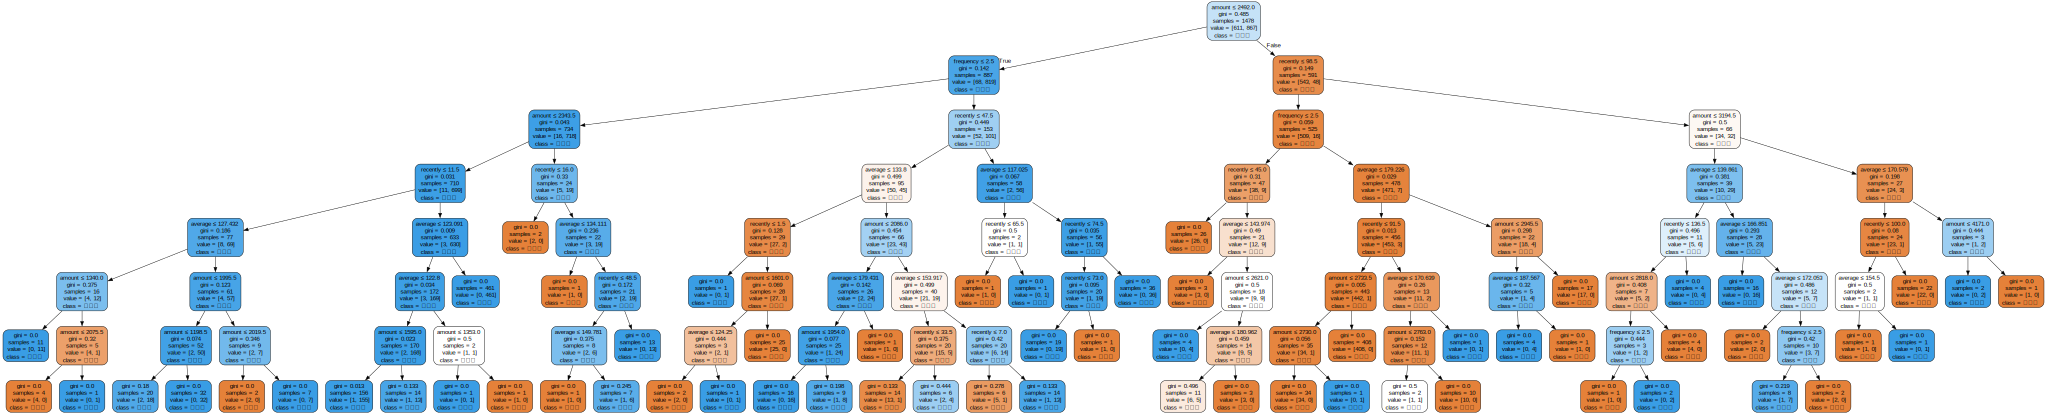

In [53]:
graphviz.Source(export_graphviz(
    grid.best_estimator_,
    out_file=None,
    feature_names=x_train_unscaled.columns,
    class_names=['非流失', '准流失'],
    rounded=True,
    filled=True,
    special_characters=True))

In [54]:
print(f"训练准确率={grid.score(x_train_unscaled, y_train)}")
print(f"验证准确率={grid.score(x_test_unscaled, y_test)}")

训练准确率=0.9878213802435724
验证准确率=0.8963133640552995


可以看出决策树模型在训练集上的准确率更高，而在测试集上的准确率较低，说明其泛化能力可能很差，发生了过拟合。